<a href="https://colab.research.google.com/github/NatasaKinzy/Data-Science/blob/main/Unit6/2_NataKinzU6Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

# Unit 6 Project: Making a Generalized Linear Model (multiple predictors)


# Context

So Penguins are cute little flightless birds who waddle around cold climates and I wanted to see if you can predict their sex based on a few different physical factors. Female penguins are generally smaller and weigh less than males so naturally sex will factor into body mass and height. However, intuitively, since height is the "length" of the penguin, I thought that we could also use flipper length and bill length as a predictor of sex. On that same vein, since bill length likely contributes, bill depth also probably factors into determining sex because (I think) the longer the bill the less depth it is likely to have.

# Data

In [ ]:
url_penguin = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/penguins.csv'
penguin = pd.read_csv(url_penguin).dropna()

In [ ]:
penguin

# Variable Selection

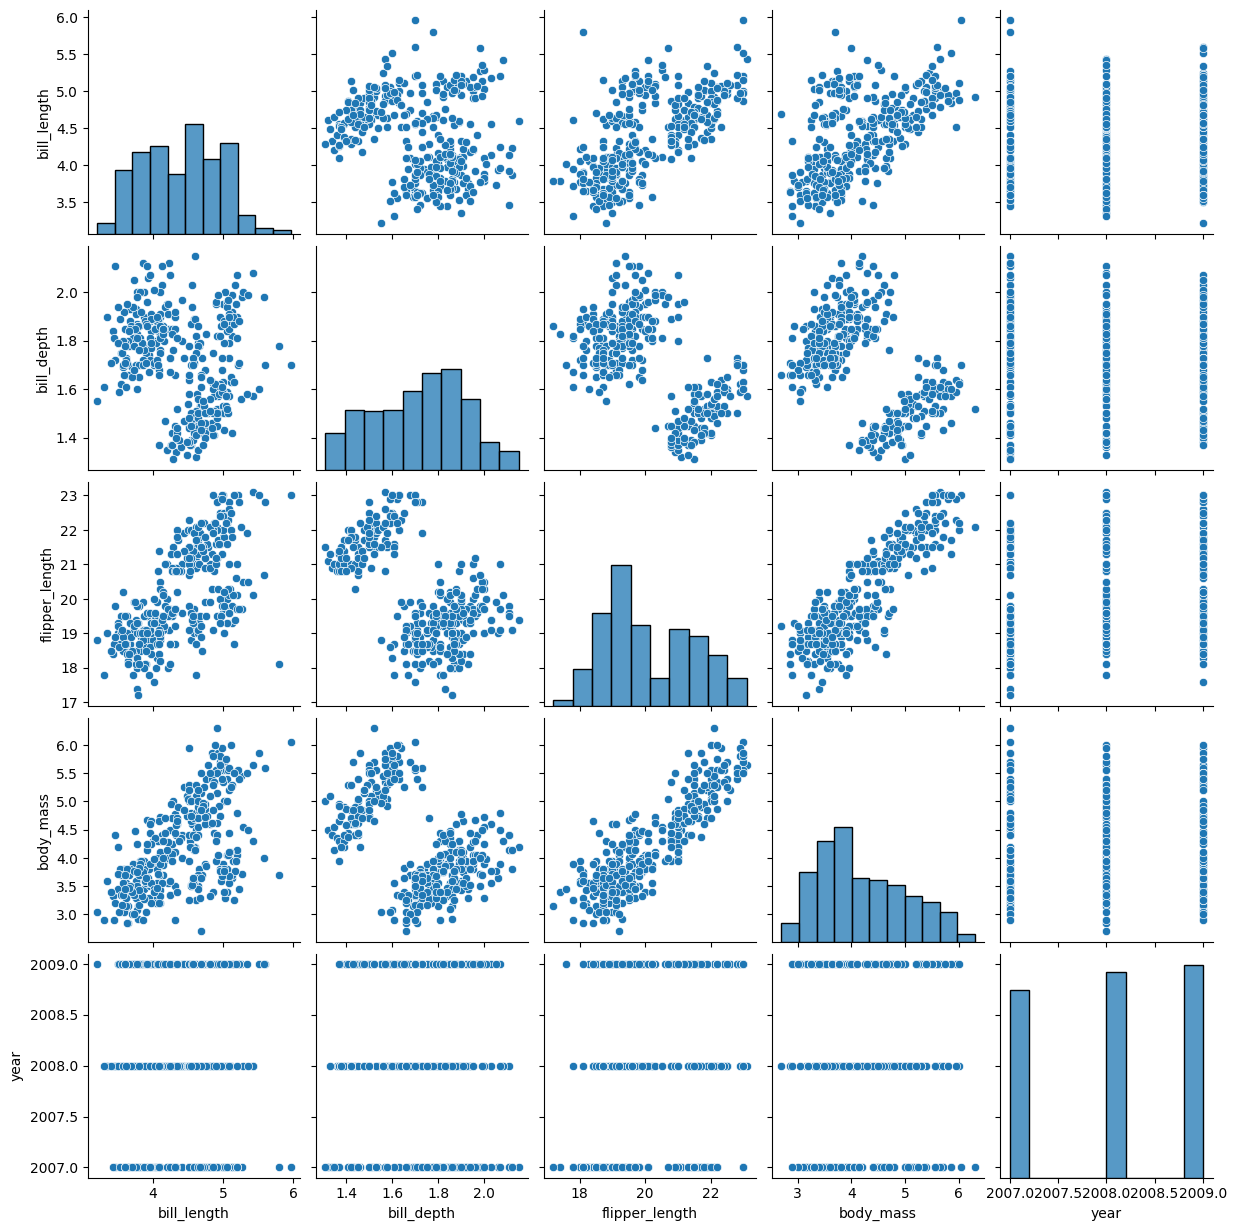

In [ ]:
#pairplot to ensure data is good.
#OMG there are patterns!!!!! Data is useable.
sns.pairplot(penguin)

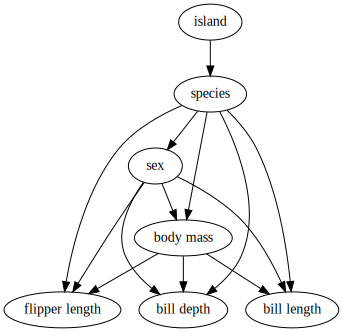

In [ ]:
dag_penguin = gv.Digraph(comment='penguin_dag') #penguin

dag_penguin.node('M', 'body mass')
dag_penguin.node('L','bill length')
dag_penguin.node('F','flipper length')
dag_penguin.node('D','bill depth')
dag_penguin.node('S','sex')
dag_penguin.node('I','island')
dag_penguin.node('C','species')

dag_penguin.edges(['IC','CM', 'CL','CD','CF', 'CS', 'SM', 'SF', 'SD', 'SL', 'MF', 'ML', 'MD'])

dag_penguin

Now we'll use Bambi to model our predictors and see which ones we should use to predict flipper length.

In [ ]:
!pip install bambi

In [ ]:
import bambi as bmb

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

In [ ]:
priors ={"species" : bmb.Prior("Normal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}
model_CO_bmb = bmb.Model("flipper_length ~ species", penguin, family = "negativebinomial", priors=priors)

In [ ]:
#this is bambi's equivalent of pm.sample()
idata_CO_bmb = model_CO_bmb.fit(idata_kwargs={"log_likelihood":True})

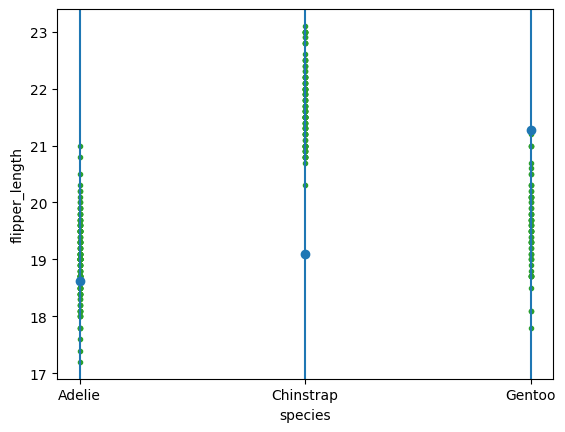

In [ ]:
bmb.interpret.plot_predictions(model_CO_bmb, idata_CO_bmb, "species", pps=True)
plt.plot(penguin.species, penguin.flipper_length, "C2.", zorder=-3)

Ok so this model looks a little funky because it's solely categorical so I'm going to add in body mass and see if that makes it better. Also, I'm pretty sure based on how the table looks that body_mass and species are very related so I'm going to make a model with both of those next.  

In [ ]:
priors ={"species + body_mass" : bmb.Prior("Normal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}
model_CM_bmb = bmb.Model("flipper_length ~ species + body_mass", penguin, family = "negativebinomial", priors=priors)

In [ ]:
idata_CM_bmb = model_CM_bmb.fit(idata_kwargs={"log_likelihood":True})

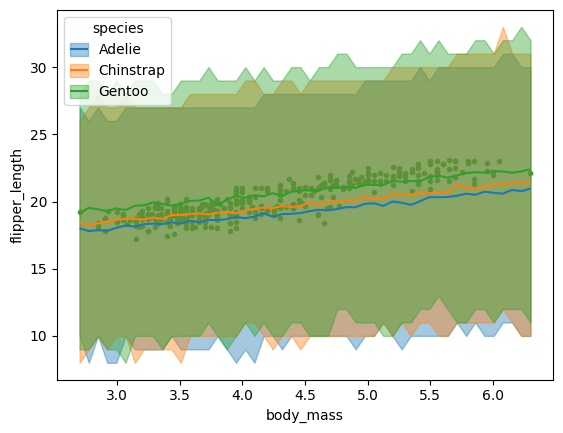

In [ ]:
bmb.interpret.plot_predictions(model_CM_bmb, idata_CM_bmb, ["body_mass", "species"], pps=True)
plt.plot(penguin.body_mass, penguin.flipper_length, "C2.", zorder=-3)

This model is pretty good but could be better so I'm going to try adding an interaction between body_mass and sex since those are pretty directly related.

In [ ]:
priors ={"species + sex:body_mass" : bmb.Prior("Normal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}
model_CMS_bmb = bmb.Model("flipper_length ~ species + sex:body_mass", penguin, family = "negativebinomial", priors=priors)

In [ ]:
idata_CMS_bmb = model_CMS_bmb.fit(idata_kwargs={"log_likelihood":True})

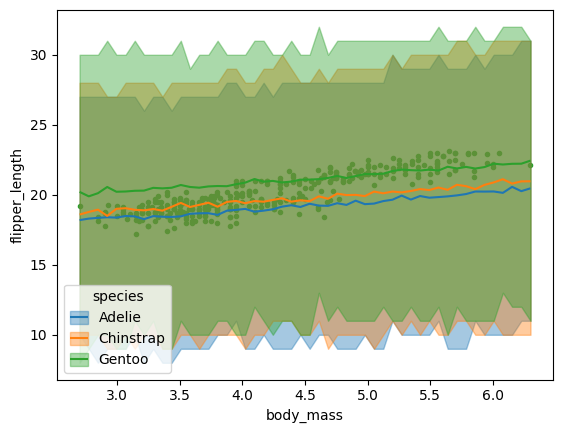

In [ ]:
bmb.interpret.plot_predictions(model_CMS_bmb, idata_CMS_bmb, ["body_mass", "species"], pps=True)
plt.plot(penguin.body_mass, penguin.flipper_length, "C2.", zorder=-3)

This is a little worse at following the dots so I'm going to interact species and body_mass this time.

In [ ]:
priors ={"species:body_mass + sex" : bmb.Prior("Normal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}
model_CMS2_bmb = bmb.Model("flipper_length ~ species:body_mass + sex", penguin, family = "negativebinomial", priors=priors)

In [ ]:
idata_CMS2_bmb = model_CMS2_bmb.fit(idata_kwargs={"log_likelihood":True})

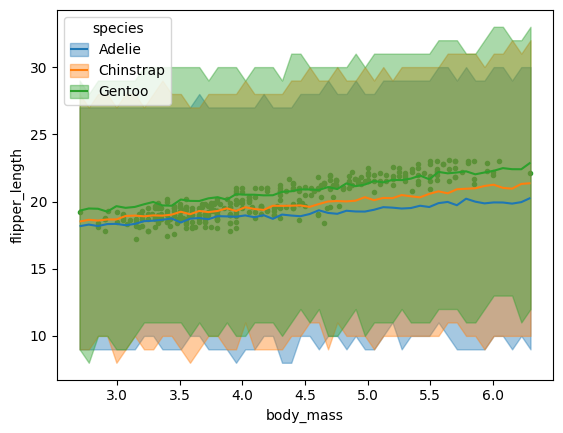

In [ ]:
bmb.interpret.plot_predictions(model_CMS2_bmb, idata_CMS2_bmb, ["body_mass", "species"], pps=True)
plt.plot(penguin.body_mass, penguin.flipper_length, "C2.", zorder=-3)

This is better at following the dots especially with the Gentoo line! Lastly I'm going to see how island, species, and body_mass affect flipper length again interacting species and body_mass.

In [ ]:
priors ={"species:body_mass + island" : bmb.Prior("Normal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}
model_CMI_bmb = bmb.Model("flipper_length ~ species:body_mass + island", penguin, family = "negativebinomial", priors=priors)

In [ ]:
idata_CMI_bmb = model_CMI_bmb.fit(idata_kwargs={"log_likelihood":True})

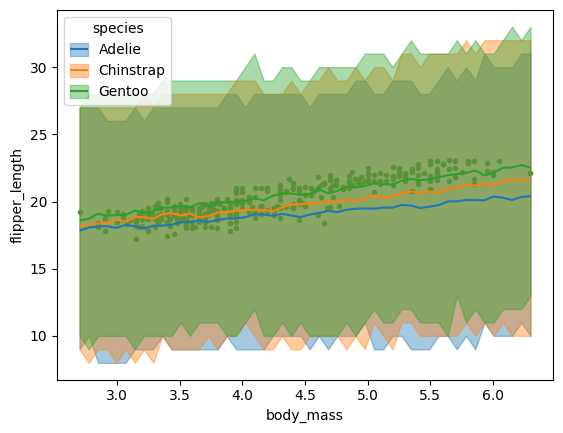

In [ ]:
bmb.interpret.plot_predictions(model_CMI_bmb, idata_CMI_bmb, ["body_mass", "species"], pps=True)
plt.plot(penguin.body_mass, penguin.flipper_length, "C2.", zorder=-3)

In [ ]:
priors ={"species + body_mass:island" : bmb.Prior("Normal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}
model_CMI2_bmb = bmb.Model("flipper_length ~ species + body_mass:island", penguin, family = "negativebinomial", priors=priors)

In [ ]:
idata_CMI2_bmb = model_CMI2_bmb.fit(idata_kwargs={"log_likelihood":True})

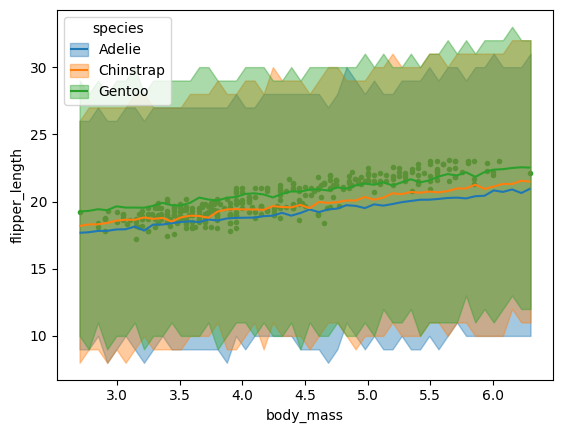

In [ ]:
bmb.interpret.plot_predictions(model_CMI2_bmb, idata_CMI2_bmb, ["body_mass", "species"], pps=True)
plt.plot(penguin.body_mass, penguin.flipper_length, "C2.", zorder=-3)

These two involving island also are a little less accurate slope wise at following the dots.

# Time to Compare!

In [ ]:
cmp_df = az.compare ({
    'Species': idata_CO_bmb,
    'Species_&_Body_mass': idata_CM_bmb,
    'Species,Body_mass:sex': idata_CMS_bmb,
    'Species:Body_mass,sex': idata_CMS2_bmb,
    'Species:Body_mass,island': idata_CMI_bmb,
    'Species,Body_mass:island': idata_CMI2_bmb
})

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

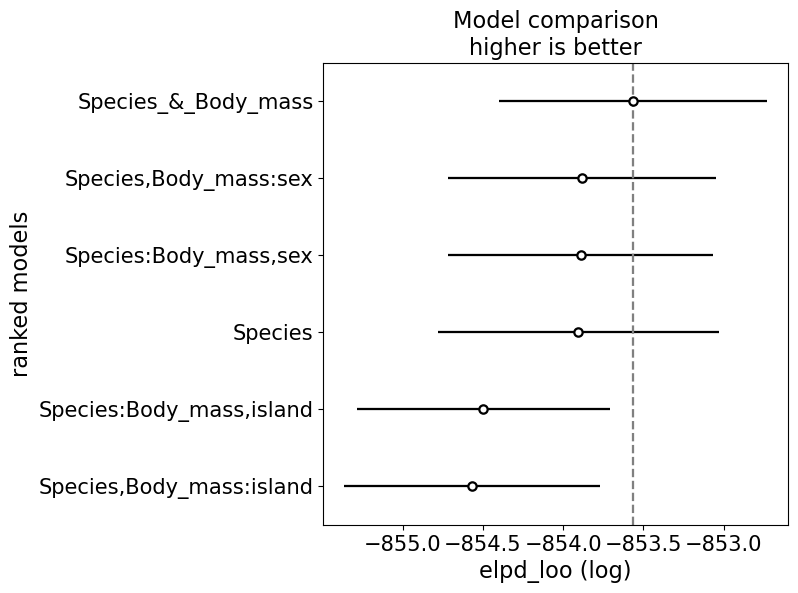

In [ ]:
az.plot_compare(cmp_df)

Ok so based on elpd_loo it seems that I should use species and body_mass as my variables to create the best model. Species, sex, and body_mass work fairly well as well but they aren't *as* good as just species and body_mass. The models which involved the islands didn't work very well so I definitely wouldn't make a model involving islands as a variable.  

# Analysis

The model that best fit my data was simply species and body mass vs flipper length according to elpd_loo and upon examining the graphs, I agree. In the posterior predictive model for CM (species and body mass vs flipper length), the Gentoo line fits the data (dots) better than any other model.

Whats going on with chinstrap and adeile?

I think the reason the best model only uses two variables is because body_mass is my only non-categorical variable to determine flipper length. If I were able to use a dataset with penguin height as well as body mass and species I think a model with those variables could have been much better at predicting flipper length as a taller penguin will almost definitely have a longer flipper than a shorter penguin.

The margin in the elpd-loo is impecably close which either means all preformed equally poorly or equally well. I believe it was equally well because species, bodymass, island, and sex are all VERY related to flipper length so the difference in using any combo of them is minimal.

There's some secret I'm missing that has to do with species and the scatter plot...